In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = "/content/drive/MyDrive/AI and Machine Learning/Week5/FruitinAmazon/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI and Machine Learning/Week5/FruitinAmazon/FruitinAmazon/test"

In [5]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['tucuma', 'acai', 'guarana', 'cupuacu', 'pupunha', 'graviola']


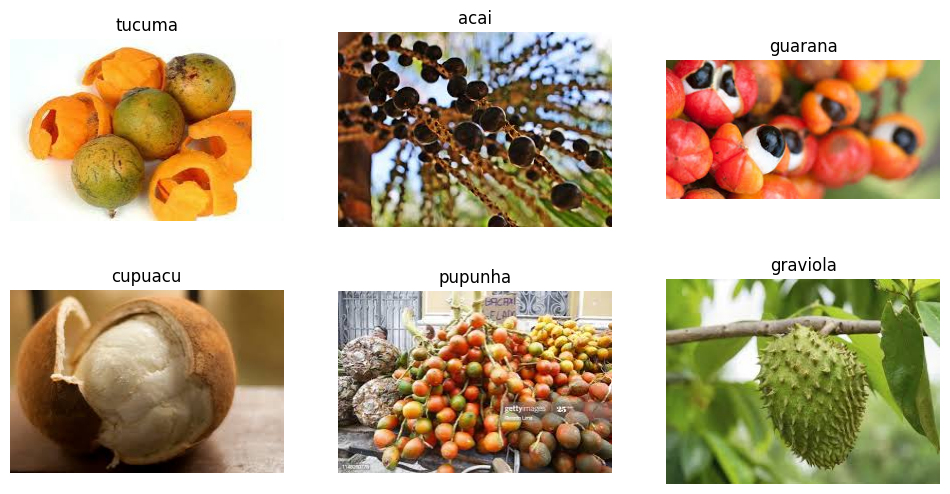

In [6]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [7]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [8]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [11]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [12]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.1447 - loss: 1.8479

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 711ms/step - accuracy: 0.1467 - loss: 1.8541 - val_accuracy: 0.1111 - val_loss: 1.6657
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.3750 - loss: 1.6609

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step - accuracy: 0.3750 - loss: 1.6605 - val_accuracy: 0.5000 - val_loss: 1.6259
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.3791 - loss: 1.4863

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3850 - loss: 1.4762 - val_accuracy: 0.7778 - val_loss: 1.1284
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 529ms/step - accuracy: 0.4167 - loss: 1.2711 - val_accuracy: 0.6667 - val_loss: 1.0117
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6186 - loss: 1.0039

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step - accuracy: 0.6272 - loss: 1.0003 - val_accuracy: 0.8889 - val_loss: 0.8055
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - accuracy: 0.8177 - loss: 0.7439 - val_accuracy: 0.8889 - val_loss: 0.6563
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.9557 - loss: 0.4745 - val_accuracy: 0.8333 - val_loss: 0.7271
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 865ms/step - accuracy: 0.9891 - loss: 0.3406 - val_accuracy: 0.8333 - val_loss: 0.4221
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - accuracy: 0.9566 - loss: 0.2192 - val_accuracy: 0.8889 - val_loss: 0.3878
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - accuracy: 1.0000 - loss: 0.1146 - val_accuracy: 0.6111 - val_loss: 0.8942
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - accuracy: 0.9635 - loss: 0.1443 - val_accuracy: 0.8889 - val_loss: 0.3206
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 1.0000 - loss: 0.0502 - val_accuracy: 0.8889 - val_loss: 

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9518 - loss: 0.1906 - val_accuracy: 0.9444 - val_loss: 0.1690
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 524ms/step - accuracy: 1.0000 - loss: 0.0342 - val_accuracy: 0.7222 - val_loss: 0.4665
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.9813 - loss: 0.0674 - val_accuracy: 0.8333 - val_loss: 0.5313
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 1.0000 - loss: 0.0531 - val_accuracy: 0.8889 - val_loss: 0.3029
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.8889 - val_loss: 0.1957
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 887ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.8889 - val_loss: 0.1424
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.8889 - val_loss: 0.1682
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.8333 - val_loss:

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7333 - loss: 0.7395
Test Accuracy: 73.33%


In [16]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
              precision    recall  f1-score   support

      tucuma       0.62      1.00      0.77         5
        acai       0.62      1.00      0.77         5
     guarana       1.00      0.40      0.57         5
     cupuacu       1.00      0.60      0.75         5
     pupunha       0.80      0.80      0.80         5
    graviola       0.75      0.60      0.67         5

    accuracy                           0.73        30
   macro avg       0.80      0.73      0.72        30
weighted avg       0.80      0.73      0.72        30



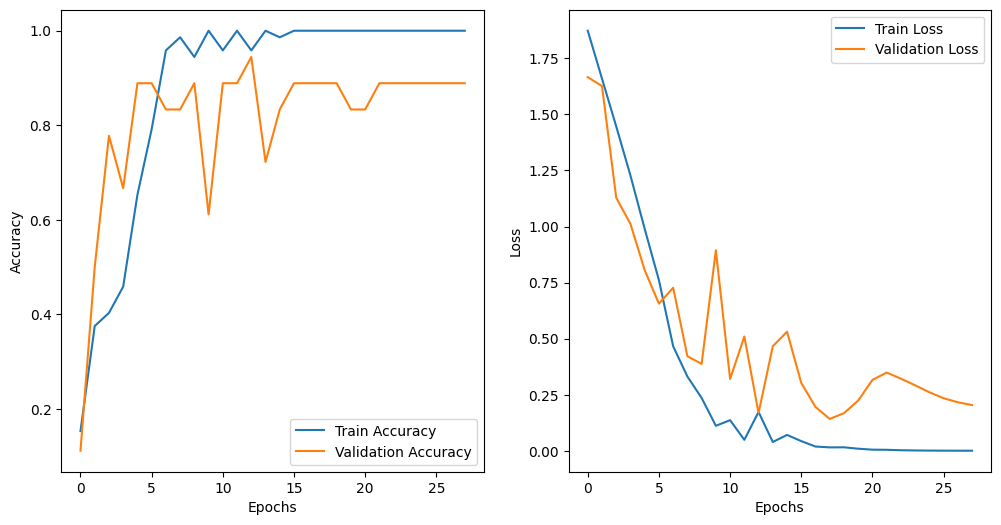

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()